# PCAによる次元削減とSVMを用いたMNISTの分類

## はじめに
      MNISTという数字手書き文字のデータセットがある。このデータは28×28ピクセルの手書き数字の画像に対して、0から9までのラベルが振られたデータである。
      このレポートでは、10000枚の手書き数字の画像がそれぞれ0から9までのどの数字にあたるかを識別する、SVMを用いたモデルの生成、および生成モデルを用いた推論を実装する。また、性能向上のために用いた交差検証、グリッドサーチ、およびPCA(主成分分析)による次元削減についても記載する。
    
## レポートの構成について
      実行したコードの記載されたセルの次のセルにコードの内容、使用した手法などの説明を記載する形になっている。

In [1]:
from operator import itemgetter
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
DATAPATH = "data/digits.csv"
image_shape=(28,28)
df = pd.read_csv(DATAPATH)
y = df["label"].values
X = df.drop("label",axis=1).values/255
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 0)

## データセットの用意
      ここでcsvからデータをロードし、画像データ、ラベルデータをそれぞれトレイン用のデータ、テスト用のデータに分割する。トレイン用のデータとテスト用のデータを分けることにより、生成したモデルの性能評価を行うことができる。
      また、ここではデータ分割にtrain_test_splitというランダムにトレインデータとテストデータを分割する関数を使用しているが、random_stateパラメータを任意に設定することで毎回同じ出力が発生するようにしてある。また、ロードしたターゲットデータは最大値の255割ってスケールしている。こうすることで学習時のパラメータ更新がパラメータごとに偏ることがなくなり、最適解を見つけるまでのステップが少なくなるというメリットがある。この処理を前処理という。

In [2]:
pca = PCA(0.8)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(pca.n_components_)
print(np.sum(pca.explained_variance_ratio_))

43
0.8013124141578981


## PCAによる次元削減
      ここでPCAによる次元削減を行う。PCAとは主成分を計算し、n次元のデータの内あるm(<<n)個の主成分でデータ全体の何%を説明できるかを分析することである。例えばここではオリジナルの画像データの分散の80%を説明できる主成分がいくつ必要かを求めている。結果、43個の変数でオリジナルの画像データの分散の80%が説明できることがわかる。次元削減を行うことで、過学習の抑制や計算時間の短縮が期待できる。

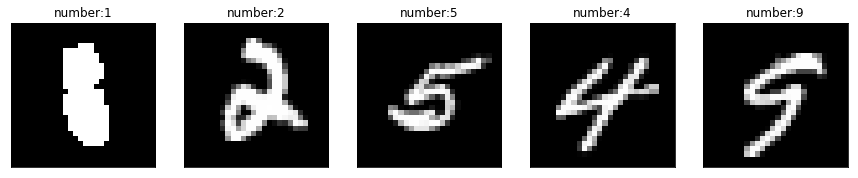

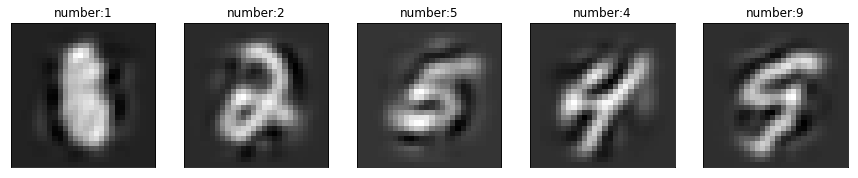

In [3]:
X_train_low = pca.inverse_transform(X_train_pca)
X_test_low = pca.inverse_transform(X_test_pca)
image_shape = [28,28]
fix, axes1 = plt.subplots(1,5,figsize=(15,12),
                        subplot_kw={"xticks":(),"yticks":()})
fix2, axes2 = plt.subplots(1,5,figsize=(15,12),
                        subplot_kw={"xticks":(),"yticks":()})

for i,ax in zip(range(5),axes1.ravel()):
    ax.imshow((X_train[i]*255).reshape(image_shape),cmap=plt.cm.gray)
    ax.set_title("number:{}".format(y_train[i]))
for i,ax in zip(range(5),axes2.ravel()):
    ax.imshow((X_train_low[i]*255).reshape(image_shape),cmap=plt.cm.gray)
    ax.set_title("number:{}".format(y_train[i]))


## 次元削減後のデータの可視化
    ここで次元削減前の画像データと次元削減後の画像データを書き出して比較してみる。上段がオリジナルのデータ、下段が各データを次元削減したのち復元したデータである。これを見ると、おおよそ元の特徴を保持しているように見える。

In [4]:
parameters = [
    {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
    {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.001, 0.0001]},
    {'C': [1, 10, 100, 1000], 'kernel': ['poly'], 'degree': [2, 3, 4], 'gamma': [0.001, 0.0001]},
    {'C': [1, 10, 100, 1000], 'kernel': ['sigmoid'], 'gamma': [0.001, 0.0001]}
    ]
clf = svm.SVC(parameters)
clf = GridSearchCV(clf, parameters, verbose=2,n_jobs=-1,cv=2,return_train_score=True)
clf.fit(X_train,y_train)
print(clf.score(X_test,y_test))

Fitting 2 folds for each of 44 candidates, totalling 88 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed: 28.0min finished


0.959


In [5]:
clf_pca = svm.SVC(parameters)
clf_pca = GridSearchCV(clf_pca, parameters, verbose=2,n_jobs=-1,cv=2,return_train_score=True)
clf_pca.fit(X_train_pca,y_train)
print(clf_pca.score(X_test_pca,y_test))

Fitting 2 folds for each of 44 candidates, totalling 88 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:  2.3min finished


0.963


In [6]:
print("Best estimator found by grid search:")
print("Best parameters:{}".format(clf.best_params_))
print("Best parameters_pca:{}".format(clf_pca.best_params_))

Best estimator found by grid search:
Best parameters:{'C': 1000, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly'}
Best parameters_pca:{'C': 1000, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly'}


## 交差検証を用いたグリッドサーチ
      ここではサポートベクターマシンを分類モデルとして用いた上で、交差検証を用いたグリッドサーチを行っている。まずサポートベクターマシン、交差検証およびグリッドサーチについて説明する。
### サポートベクターマシン
      本レポートにおける分類モデルのアルゴリズムにはサポートベクターマシンを使用している。
      サポートベクターマシンとは、線形識別機における重みベクトル、バイアスなどのパラメータ設定をマージン最大化の考えを以て定めるというものである。
      マージンとはデータ分類の決定境界と、各クラスのデータ点の最短距離を指す。つまり、求める決定境界が各クラスのデータからなるべく離れたこところに設定するというのがマージン最大化の考え方である。

<img src="./images/margin_img.png">

      例えば上図の左右の絵を比べてみると、右の絵の方が直線と各クラスの最短の点との距離が左の絵よりも長くなっている。この距離がマージンであり、このマージンを最大化するように境界を求めるというのがサポートベクターマシンの考え方である。

### 交差検証
      交差検証とは汎化性能を評価する統計的手法である。トレインデータとテストデータの分割を一度だけではなく複数行い、複数の分割方法でそれぞれモデルを訓練する。例えば一度の分割によってクラス分類が難しいデータばかりトレインデータになり、テストデータが簡単なデータばかりになってしまうと、異常に高い精度を得ることとなってしまう。
      交差検証を行うことで、個々のサンプルがいずれかの分割に含まれている上に、全てのデータが一度だけテストに用いられているので、全てのデータが一度だけテストに用いられることになる。よって、モデルが全サンプルに対して高い汎化性能を持たなければ、交差検証スコアと平均を高くできない。逆に言うと、スコアと平均を見ることにより、訓練したモデルの汎化性能を評価できる。
### グリッドサーチ
      機械学習で用いられるモデルには様々なパラメータが設定されている。本レポートで使用するサポートベクターマシンにおいても、正則化項、カーネルの種類、カーネルの幅など様々に設定可能なパラメータを持つ。このパラメータを調整することによってモデルの性能を向上させることができる。
      あらかじめ複数のパラメータを用意し、それら全ての組み合わせに対して訓練を行い、性能を確認する手法をグリッドサーチという。ScikitLearnにはGridsearchCVという交差検証を行いながらグリッドサーチを行う関数が用意されており、今回はこれを用いる。
      ただしグリッドサーチには計算時間が増大するというデメリットもある。3×3のパラメータを用意し、かつ3分割交差検証を行うとすると、計27回の訓練を行わなくてはならない。
    
## グリッドサーチの実行
### グリッドサーチの内容について
    ここで設定したパラメータの組み合わせに対して交差検証を用いたグリッドサーチを行う。44のパラメータ組み合わせに対して2分割交差検証を行っているので、計88回の訓練が行われる。2分割交差検証は交差検証の分割数としては少なく、精度が低下する可能性があるが、グリッドサーチにおいては各パラメータの大小を比較するのが大目的なので大きな問題はない。
### 実行結果
    グリッドサーチの結果、オリジナルの画像データ、次元削減した画像データどちらの場合でも、与えたパラメータの中ではC=1000,kernel="poly",degree=2,gamma=0.001の組み合わせが最もよく、テストデータに対して約96%の正答率を返した。しかし実行時間を比較すると、削減前の28分から2.3分まで減少しており、PCAによってモデルの分類精度を維持しつつ、計算コストを減少させることが可能であることを示す結果となった。

In [7]:
clf_cv = svm.SVC(C=1000,degree=2,gamma=0.001,kernel="poly")
print("Normal CV score:",cross_val_score(clf_cv,X_train,y_train,cv=5,verbose=2,n_jobs=-1))
print("PCA CV score:",cross_val_score(clf_cv,X_train_pca,y_train,cv=5,verbose=2,n_jobs=-1))

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.3s finished


Normal CV score: [0.96323988 0.95942572 0.95309568 0.95682103 0.95551378]
PCA CV score: [0.96448598 0.96067416 0.95559725 0.95932416 0.95864662]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


## 実行結果の検証
    交差検証を用いたグリッドサーチ2分割交差検証は分割数として少ないので、再度5分割交差検証を行って交差検証を行っている。こちらもおおよそ96%程度の正答率を返しており、高精度かつ汎化性能の高いモデルを構築できたと言える。

In [8]:
cv_result_df = pd.DataFrame(clf_pca.cv_results_)
pd.set_option('display.max_colwidth',100)
maxidx = cv_result_df["mean_test_score"].idxmax()
minidx = cv_result_df["mean_test_score"].idxmin()
print(cv_result_df.loc[maxidx,["params","mean_test_score"]])
print(cv_result_df.loc[minidx,["params","mean_test_score"]])

params             {'C': 1000, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly'}
mean_test_score                                                      0.952125
Name: 30, dtype: object
params             {'C': 1, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly'}
mean_test_score                                                    0.10925
Name: 12, dtype: object


    また次元削減後の画像データを用いたモデルでのグリッドサーチを行った全てのパラメータの内、平均テストスコアが最大のものと最小のものを比較してみる。最大のスコアは0.95,最小は0.11となっており、パラメータ調整によって性能が大きく変化することが見て取れ、パラメータ調整の重要性、およびグリッドサーチの有用性を示す結果となった。

In [9]:
y_pred_pca = clf_pca.predict(X_test_pca)
print(metrics.classification_report(y_test, y_pred_pca, 
                                    target_names=["0","1","2","3","4","5","6","7","8","9"]))
print(metrics.confusion_matrix(y_test, y_pred_pca, labels=range(10)))

             precision    recall  f1-score   support

          0       0.98      0.98      0.98       204
          1       0.97      0.99      0.98       221
          2       0.97      0.96      0.97       173
          3       0.96      0.94      0.95       218
          4       0.96      0.97      0.96       197
          5       0.94      0.99      0.96       183
          6       0.98      0.98      0.98       202
          7       0.99      0.97      0.98       223
          8       0.95      0.94      0.94       183
          9       0.94      0.92      0.93       196

avg / total       0.96      0.96      0.96      2000

[[200   0   1   1   0   0   2   0   0   0]
 [  0 218   0   2   0   0   0   0   1   0]
 [  0   2 166   0   2   0   0   2   1   0]
 [  0   0   1 204   1   1   1   0   4   6]
 [  0   2   0   1 191   0   0   0   0   3]
 [  0   0   0   0   0 181   0   0   2   0]
 [  2   0   0   0   0   1 197   0   2   0]
 [  1   1   1   0   0   2   0 216   0   2]
 [  0   0   0   4

## 結果考察
### classification_reportと混同行列を用いたラベル毎の分類結果表示
      次元削減後の画像データの分類結果について考察を行う。
    まず上段の表はscikit-learnのclassification_reportによって出力されたものである。precisionは分類モデルが予測した結果が正解していた割合である。recallは画像データが持っていたラベルの内正解と予測された割合である。f1_scoreはprecisionとrecallの調和平均である。これより、9に対するスコアが最も低いことがわかる。  
      下段の表は混同行列である。混同行列はラベルに画像データの与えられたラベルに対して、分類モデルによって推定されたラベルの結果がどう予測されたかを示すものである。例えば10行1列の2という値は、ラベル"9"の画像データに対して、"0"と予測されたデータが2つ存在しているということを示す。これを見ると、9は間違えられた場合、万遍なく他のラベルと予測されていることがわかる。また、9行目を見ると8が3に4回間違われ、3行目を見ると3が8にに4回間違われていることがわかる。そこで3と8の分類が困難であるのではないかと推測される。
      以降では、9の分類精度が低いことと、3と8の分類の困難さに注目して結果を考察していく。

In [10]:
def wrong_listup(target_num,pred_num,y_test,y_pred,same_num):
    output_list=[]
    for counter,i in enumerate(y_test):
        if y_test[counter] == target_num:
            if same_num:
                if y_pred[counter] != pred_num:
                    keep_list = [counter,y_pred[counter]]
                    output_list.append(keep_list)
            else :
                if y_pred[counter] == pred_num:
                    keep_list = [counter,y_pred[counter]]
                    output_list.append(keep_list)
    col_num = 1
    output_list.sort(key=itemgetter(1))
    return output_list
wrong_prediction_9 = wrong_listup(9,9,y_test,y_pred_pca,True)
wrong_prediction_8 = wrong_listup(8,3,y_test,y_pred_pca,False)
wrong_prediction_3 = wrong_listup(3,8,y_test,y_pred_pca,False)

### 分類を失敗したデータのリスト化
      ここで分類に失敗したデータのリスト化を行う。ラベルが9の画像データの内9と分類されなかったもの、ラベルが8の画像データの内3と分類されたもの、ラベルが3の内8と分類されたもののそれぞれの画像データのインデックスのリストを作成する。

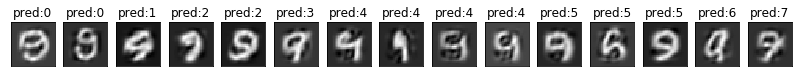

In [11]:
fix, axes = plt.subplots(1,len(wrong_prediction_9),figsize=(14,14),
                        subplot_kw={"xticks":(),"yticks":()})
for i,ax in zip(wrong_prediction_9,axes.ravel()):
    ax.imshow(X_test_low[i[0]].reshape(image_shape),cmap=plt.cm.gray)
    ax.set_title("pred:{}".format(i[1]))  

### ラベル9の分類失敗画像データの表示
      ここでラベル9の画像データの内、分類を失敗した画像を表示している。画像上部の値はどの値に間違って分類されたかを示している。画像と間違った分類を見比べてみると、例えば0に分類されたものは0ににた様な一円のような形状をした9が描かれていたり、9の右上のあたりが分離して4のような形状になっている9は4に分類されているなど、他の数字の特徴に近い形状をしているものが誤分類されていることがわかる。

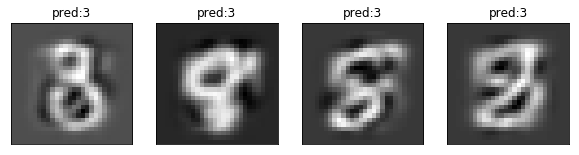

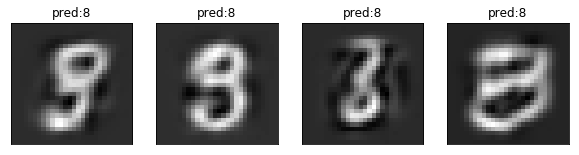

In [12]:
fix, axes = plt.subplots(1,len(wrong_prediction_8),figsize=(10,10),
                        subplot_kw={"xticks":(),"yticks":()})
for i,ax in zip(wrong_prediction_8,axes.ravel()):
    ax.imshow(X_test_low[i[0]].reshape(image_shape),cmap=plt.cm.gray)
    ax.set_title("pred:{}".format(i[1]))
fix, axes = plt.subplots(1,len(wrong_prediction_3),figsize=(10,10),
                        subplot_kw={"xticks":(),"yticks":()})
for i,ax in zip(wrong_prediction_3,axes.ravel()):
    ax.imshow(X_test_low[i[0]].reshape(image_shape),cmap=plt.cm.gray)
    ax.set_title("pred:{}".format(i[1]))

### ラベル8と3の分類失敗画像データの表示
      続いてラベル8の画像の内3と間違えたものと、ラベル3の内8と間違えたものを表示する。それぞれ上段、下段に表示しているが、上段左上の8はほぼ3のような特徴がはっきり見えており、また下段右下の3は端点がくっつくような形で8のような特徴を示している。こちらの場合もラベル9の誤分類と同様に、他の数字と似たような特徴を持っているが故に誤分類が発生していることがわかる。

## 解決案
      ここまで述べてきた通り、この分類モデルでは誤分類がいくつか発生している。誤分類を低下させ、分類精度を向上させる案をいくつか提示する。
### データ数の加増
      トレインデータを増やすことで、現状のデータ数では分類することのできなかった細かい特徴についても学習し、分類できるようになる可能性がある。ただしデータ数の加増は計算コストの増加を引き起こす可能性もある。
### パラメータの調整
      本レポートでは分類モデルのパラメータ調整にグリッドサーチを用いたが、結局は設定したパラメータの内からパラメータを選択したのみなので、今回設定していないパラメータの方がより高精度な分類モデルを構築できる可能性がある。ただし、あまりに細かい特徴まで分類できるようなパラメータ設定のモデルは汎化性能が低下してしまう恐れがあるため、交差検証などの汎化性能の利用は必須である。
### 別の分類アルゴリズムの利用
      本レポートではサポートベクターマシンを分類のアルゴリズムとして用いているが、他にも分類問題を解くためのアルゴリズムは存在している。例えば畳みこみニューラルネットワークを用いれば、MNISTに対して99%以上の精度を誇る分類モデルを構築できたという報告もある。

### まとめと今後
      PCAを用いた次元削減を用いた結果、グリッドサーチのような計算コストが増大しやすい手法でも計算コストを抑えつつ、分類モデルの精度を維持しながら使用できることが示せた。またグリッドサーチを用いることで、適切なパラメータ設定に成功し、高精度かつ高汎化性能を持ったモデルを構築できた。
      また、誤分類の発生した画像データを可視化して確認したところ、他のラベルに似た特徴を持っていることで誤分類が発生していることがわかった。
      今後は解決策に挙げたような方法で誤分類を減らせるようなモデルの作成や、パラメータ調整をグリッドサーチではなく、ベイズ最適化を用いた効率的な探索も実装していきたい。